In [1]:
from hsflfm.processing import Aligner, StrikeProcessor
from hsflfm.analysis import ResultPlotter, world_frame_to_pixel
from hsflfm.util import (
    MetadataManager,
    load_dictionary,
    save_dictionary,
    matmul,
    rot_trans_from_matrix,
    matrix_from_rot_trans,
)
from hsflfm.calibration import FLF_System
from hsflfm.ant_model import key_features_ant
from matplotlib import pyplot as plt
import os
import torch
from tqdm import tqdm
import numpy as np
import math

In [2]:
specimen_numbers = MetadataManager.all_specimen_numbers()

In [109]:
for i, num in enumerate(specimen_numbers):
    if i != 17:
        continue


    print(num, f"specimen {i} of {len(specimen_numbers)}")

    data_manager = MetadataManager(num)

    aligner = Aligner(num)


    A1, s1 = aligner.run_base_alignment()

    if i == 12:
        # we actually want to use a different A for starting out
        x = 2.49 + 0.329
        y = 1.514 + 0.133
        z = -0.122 + -0.003
        import math

        roll = -0.222 + 0.101229
        pitch = -0.13731 + -0.17453
        yaw = -2.9792 + 0

        A_ = matrix_from_rot_trans(x, y, z, roll, pitch, yaw)
        A1_start = np.linalg.inv(A_)

    # elif i == 1:
    #     x = 2.745
    #     y = 2.748
    #     z = -0.104
    #     roll = 0.231
    #     pitch = 0.338
    #     yaw = -3.08
    #     A_ = matrix_from_rot_trans(x, y, z, roll, pitch, yaw)
    #     A1_start = np.linalg.inv(A_)
    else:
        A1_start = A1

    A2, s2 = aligner.refine_matrix(
        A1_start, s1, aligner.point_camera_locations, change_scale=True
    )


    mp1 = aligner.move_points_to_mesh(A1, s1, aligner.point_camera_locations)

    mp2 = aligner.move_points_to_mesh(A2, s2, aligner.point_camera_locations)


    print("done!")

    # if i > 0:

    #    break
    # break

    print("scale change: ", s1, s2)

20240503_OB_5 specimen 17 of 29
done!
scale change:  1784.762181091278 1709.5043090084928


In [110]:
print(np.asarray(rot_trans_from_matrix(A1)))
print(np.asarray(rot_trans_from_matrix(A2)))

[ 2.49246589e+00  2.12661477e+00  5.34496813e-01  7.23701207e-02
  2.59544553e-03 -3.07676845e+00]
[ 2.43788976  2.13109451  0.65735275  0.03109377 -0.00327083 -3.07570087]


In [111]:
# maybe show mesh points before and after fine alignment?
p = np.concatenate((mp1, mp2))
values = ["blue"] * len(mp1) + ["red"] * len(mp2)
# values[len(mp1):] = 1
ResultPlotter.plot_mesh_with_points(
    points=p, point_values=values, use_display_mesh=False, opacity=0.5
)
# ResultPlotter.plot_mesh_with_points(points=mp1, point_values='blue')

In [112]:
15 * math.pi / 180

0.2617993877991494

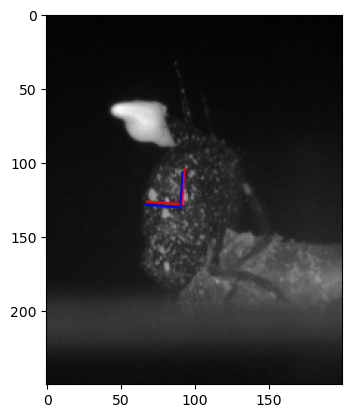

In [113]:
# show coordinate system on picture
# before and after fine alignment
system = FLF_System(data_manager.calibration_filename)
image = data_manager.get_start_images(strike_number=1)

scale = 0.5
points = [[0, 0, 0], [scale, 0, 0], [0, scale, 0]]

cam_points = matmul(np.linalg.inv(A2), points)
pixels = np.asarray([world_frame_to_pixel(system, i) for i in cam_points]).squeeze().T
plt.imshow(image[2], cmap="gray")
plt.plot(pixels[1, :2], pixels[0, :2], "-", color="red")
plt.plot([pixels[1, 0], pixels[1, 2]], [pixels[0, 0], pixels[0, 2]], color="red")

cam_points = matmul(np.linalg.inv(A1_start), points)
pixels = np.asarray([world_frame_to_pixel(system, i) for i in cam_points]).squeeze().T
plt.imshow(image[2], cmap="gray")
plt.plot(pixels[1, :2], pixels[0, :2], "-", color="blue")
plt.plot([pixels[1, 0], pixels[1, 2]], [pixels[0, 0], pixels[0, 2]], color="blue")

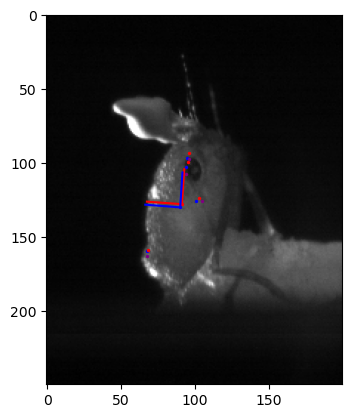

In [114]:
# show coordinate system on picture
# before and after fine alignment
system = FLF_System(data_manager.calibration_filename)
image = data_manager.light_calibration_images

scale = 0.5
points = [[0, 0, 0], [scale, 0, 0], [0, scale, 0]]

cam_points = matmul(np.linalg.inv(A2), points)
pixels = np.asarray([world_frame_to_pixel(system, i) for i in cam_points]).squeeze().T
plt.imshow(image[2], cmap="gray", alpha=1)

dark_image = data_manager.get_start_images(strike_number=1)[2]
# plt.imshow(dark_image, cmap='gray', alpha=0.4)

plt.plot(pixels[1, :2], pixels[0, :2], "-", color="red")
plt.plot([pixels[1, 0], pixels[1, 2]], [pixels[0, 0], pixels[0, 2]], color="red")

cam_points = matmul(np.linalg.inv(A1_start), points)
pixels = np.asarray([world_frame_to_pixel(system, i) for i in cam_points]).squeeze().T

plt.plot(pixels[1, :2], pixels[0, :2], "-", color="blue")
plt.plot([pixels[1, 0], pixels[1, 2]], [pixels[0, 0], pixels[0, 2]], color="blue")

for key, p in key_features_ant.items():
    p = np.asarray(p) / s1
    cam_point = matmul(np.linalg.inv(A1_start), [p])[0]
    pixel = world_frame_to_pixel(system, cam_point)
    plt.scatter(pixel[1], pixel[0], color="blue", s=2)

for key, p in key_features_ant.items():
    p = np.asarray(p) / s2
    cam_point = matmul(np.linalg.inv(A2), [p])[0]
    pixel = world_frame_to_pixel(system, cam_point)
    plt.scatter(pixel[1], pixel[0], color="red", s=2)

ap = load_dictionary(data_manager.alignment_points_filename)[2]
for p in ap:
    plt.scatter(p[1], p[0], color="purple", s=2)

In [72]:
ap = load_dictionary(data_manager.alignment_points_filename)

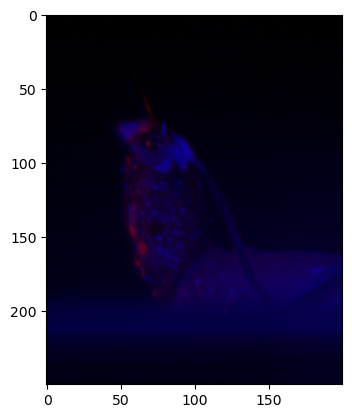

In [48]:
img = image[2]
c_img = np.zeros((img.shape[0], img.shape[1], 3))
c_img[:, :, 0] = img / 3
c_img[:, :, 2] = dark_image * 3

plt.imshow(c_img / 255)

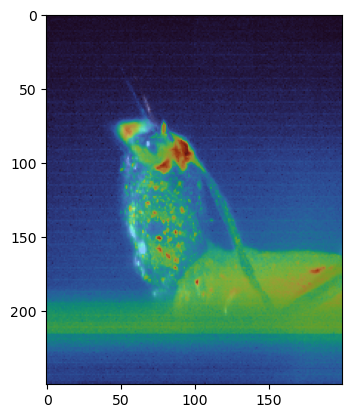

In [49]:
plt.imshow(dark_image, cmap="turbo")
plt.imshow(img, cmap="gray", alpha=0.4)

In [ ]:
# samples of concern:
# 20240427_OB_5
# 20240430_OB_2
# 20240502_OB_2
# 20240430_OB_2

# Good examples:
# 20240430_OB_2